# Phân Tích Toàn Diện ArcFace Model

Notebook này thực hiện phân tích và trực quan hóa toàn bộ kết quả training và đánh giá của mô hình ArcFace.

## Nội dung:
1. **Training Analysis**: Loss curves, Accuracy curves, Learning trajectory
2. **Evaluation Metrics**: Top-1/Top-5 Accuracy, AUC, EER
3. **ROC Curve Analysis**: Đường cong ROC chi tiết
4. **Threshold Analysis**: Phân tích ngưỡng quyết định
5. **Confusion Matrix**: Ma trận nhầm lẫn
6. **t-SNE Visualization**: Phân bố embedding
7. **Model Configuration**: Cấu hình huấn luyện
8. **Báo cáo tổng hợp**: Đánh giá toàn diện

## 1. Setup và Import

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, Markdown, Image
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

LOGS_DIR = Path('../logs/arcface')
print(f"Logs directory: {LOGS_DIR.absolute()}")
print(f"Các file có sẵn:")
for f in sorted(LOGS_DIR.glob('*')):
    print(f"  - {f.name} ({f.stat().st_size / 1024:.1f} KB)")

Logs directory: d:\HCMUTE_project\DIP\FaceRecognition\notebooks\..\logs\arcface
Các file có sẵn:
  - baseline_comparison.png (131.3 KB)
  - confusion_matrix.png (42.0 KB)
  - confusion_matrix_values.csv (0.9 KB)
  - evaluation_report.json (0.4 KB)
  - evaluation_report_v2.json (0.5 KB)
  - evaluation_visualization.png (70.1 KB)
  - gap_warning_analysis.png (75.0 KB)
  - roc_curve.png (61.3 KB)
  - roc_curve_data.csv (14.2 KB)
  - threshold_analysis.png (56.0 KB)
  - threshold_analysis_data.csv (0.8 KB)
  - throughput.png (44.8 KB)
  - training_curves.png (183.2 KB)
  - training_history.json (5.1 KB)
  - training_visualization_merged.png (233.8 KB)
  - tsne.png (78.9 KB)
  - tsne_points.csv (8.3 KB)


## 2. Load Dữ Liệu

In [2]:
with open(LOGS_DIR / 'training_history.json', 'r') as f:
    training_data = json.load(f)

with open(LOGS_DIR / 'evaluation_report_v2.json', 'r') as f:
    eval_report = json.load(f)

roc_data = pd.read_csv(LOGS_DIR / 'roc_curve_data.csv')
threshold_data = pd.read_csv(LOGS_DIR / 'threshold_analysis_data.csv')
confusion_matrix = pd.read_csv(LOGS_DIR / 'confusion_matrix_values.csv', index_col=0)
tsne_data = pd.read_csv(LOGS_DIR / 'tsne_points.csv')

history = training_data['history']
config = training_data['config']

print("Data loaded successfully!")
print(f"Training epochs: {len(history['epoch'])}")
print(f"ROC data points: {len(roc_data)}")
print(f"t-SNE points: {len(tsne_data)}")

Data loaded successfully!
Training epochs: 110
ROC data points: 378
t-SNE points: 208


---
# PHẦN 1: PHÂN TÍCH QUÁ TRÌNH TRAINING
---

## 3. Training Curves - Loss và Accuracy

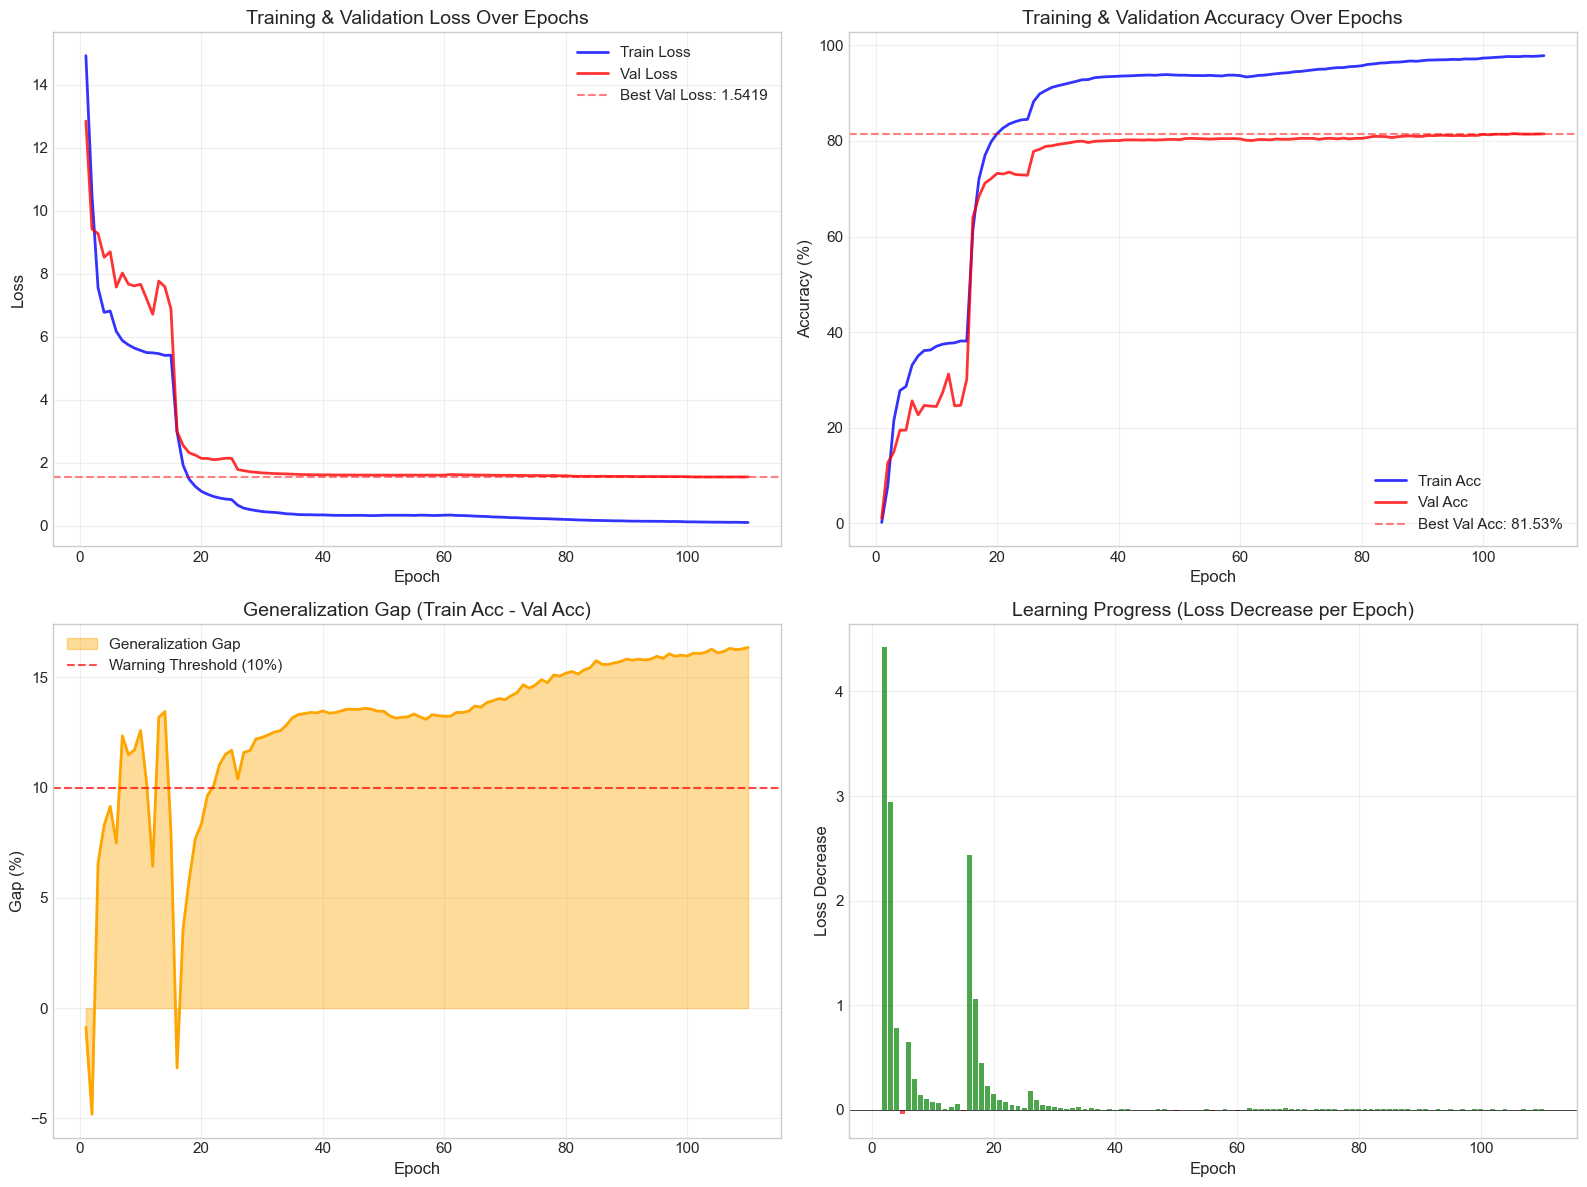


Figure saved to: ..\logs\arcface\comprehensive_training_analysis.png


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = history['epoch']

ax1 = axes[0, 0]
ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss', alpha=0.8)
ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Val Loss', alpha=0.8)
ax1.axhline(y=min(history['val_loss']), color='r', linestyle='--', alpha=0.5, label=f'Best Val Loss: {min(history["val_loss"]):.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss Over Epochs')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(epochs, history['train_acc'], 'b-', linewidth=2, label='Train Acc', alpha=0.8)
ax2.plot(epochs, history['val_acc'], 'r-', linewidth=2, label='Val Acc', alpha=0.8)
ax2.axhline(y=max(history['val_acc']), color='r', linestyle='--', alpha=0.5, label=f'Best Val Acc: {max(history["val_acc"]):.2f}%')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Validation Accuracy Over Epochs')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
train_acc = np.array(history['train_acc'])
val_acc = np.array(history['val_acc'])
gap = train_acc - val_acc
ax3.fill_between(epochs, 0, gap, alpha=0.4, color='orange', label='Generalization Gap')
ax3.plot(epochs, gap, 'orange', linewidth=2)
ax3.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Warning Threshold (10%)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Gap (%)')
ax3.set_title('Generalization Gap (Train Acc - Val Acc)')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
train_loss = np.array(history['train_loss'])
loss_diff = np.diff(train_loss)
ax4.bar(epochs[1:], -loss_diff, color=['green' if x > 0 else 'red' for x in -loss_diff], alpha=0.7)
ax4.axhline(y=0, color='black', linewidth=0.5)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss Decrease')
ax4.set_title('Learning Progress (Loss Decrease per Epoch)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'comprehensive_training_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {LOGS_DIR / 'comprehensive_training_analysis.png'}")

## 4. Phân Tích Chi Tiết Learning Phases

In [4]:
epochs_arr = np.array(history['epoch'])
train_loss_arr = np.array(history['train_loss'])
val_loss_arr = np.array(history['val_loss'])
train_acc_arr = np.array(history['train_acc'])
val_acc_arr = np.array(history['val_acc'])

phases = [
    ('Phase 1: Initial', 1, 15),
    ('Phase 2: Early', 16, 25),
    ('Phase 3: Mid', 26, 60),
    ('Phase 4: Late', 61, 90),
    ('Phase 5: Fine-tune', 91, 110)
]

print("=" * 80)
print("PHÂN TÍCH CÁC GIAI ĐOẠN HUẤN LUYỆN")
print("=" * 80)

phase_stats = []
for phase_name, start, end in phases:
    mask = (epochs_arr >= start) & (epochs_arr <= end)
    stats = {
        'Phase': phase_name,
        'Epochs': f'{start}-{end}',
        'Train Loss Start': train_loss_arr[start-1],
        'Train Loss End': train_loss_arr[min(end-1, len(train_loss_arr)-1)],
        'Val Acc Start': val_acc_arr[start-1],
        'Val Acc End': val_acc_arr[min(end-1, len(val_acc_arr)-1)],
        'Improvement': val_acc_arr[min(end-1, len(val_acc_arr)-1)] - val_acc_arr[start-1]
    }
    phase_stats.append(stats)

phase_df = pd.DataFrame(phase_stats)
display(phase_df.style.format({
    'Train Loss Start': '{:.4f}',
    'Train Loss End': '{:.4f}',
    'Val Acc Start': '{:.2f}%',
    'Val Acc End': '{:.2f}%',
    'Improvement': '{:+.2f}%'
}).background_gradient(subset=['Improvement'], cmap='RdYlGn'))

PHÂN TÍCH CÁC GIAI ĐOẠN HUẤN LUYỆN


,Phase,Epochs,Train Loss Start,Train Loss End,Val Acc Start,Val Acc End,Improvement
0,Phase 1: Initial,1-15,14.9238,5.4120,1.07%,30.17%,+29.10%
1,Phase 2: Early,16-25,2.9735,0.8225,63.94%,72.83%,+8.89%
2,Phase 3: Mid,26-60,0.6437,0.3294,77.84%,80.43%,+2.59%
3,Phase 4: Late,61-90,0.3338,0.1429,80.15%,80.97%,+0.82%
4,Phase 5: Fine-tune,91-110,0.1397,0.0965,81.14%,81.48%,+0.34%


## 5. Scheduler Effect Analysis

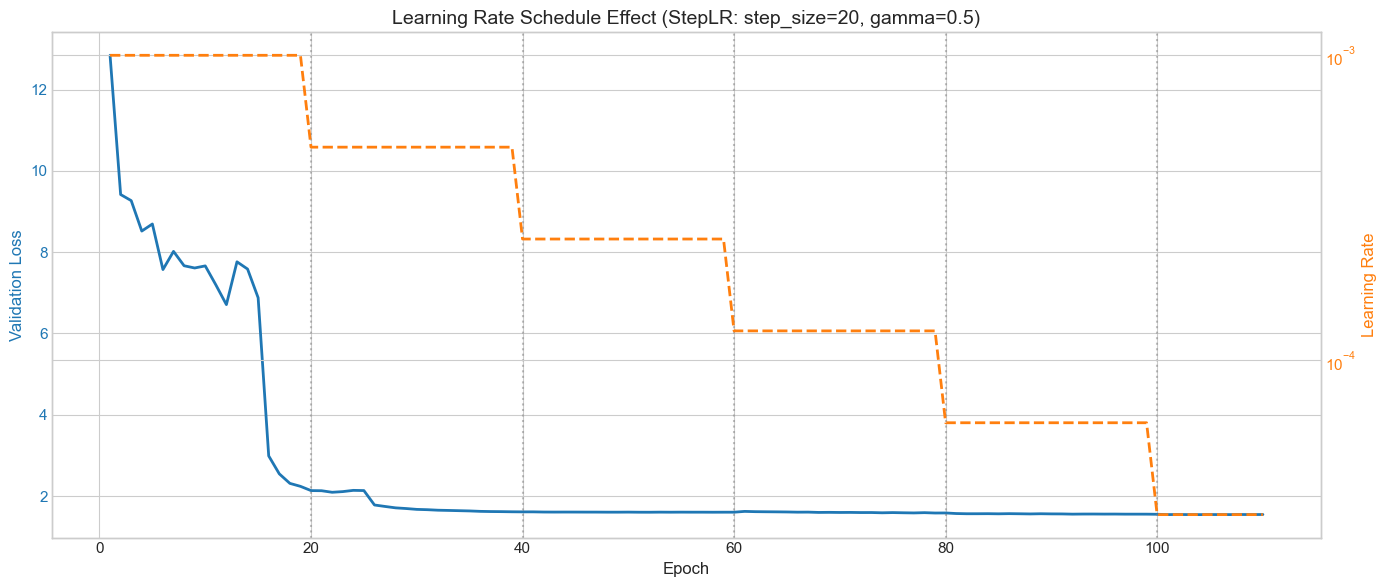

In [5]:
step_size = config['training']['scheduler']['step_size']
gamma = config['training']['scheduler']['gamma']
initial_lr = config['training']['optimizer']['lr']

lr_schedule = []
for epoch in epochs:
    lr = initial_lr * (gamma ** (epoch // step_size))
    lr_schedule.append(lr)

fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(epochs, history['val_loss'], color=color, linewidth=2, label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(epochs, lr_schedule, color=color, linewidth=2, linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

for i in range(1, len(epochs) // step_size + 1):
    ax1.axvline(x=i*step_size, color='gray', linestyle=':', alpha=0.5)

ax1.set_title(f'Learning Rate Schedule Effect (StepLR: step_size={step_size}, gamma={gamma})')
fig.tight_layout()
plt.savefig(LOGS_DIR / 'lr_schedule_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
# PHẦN 2: ĐÁNH GIÁ HIỆU NĂNG MODEL
---

## 6. Evaluation Metrics Summary

In [ ]:
metrics = eval_report['metrics']
performance = eval_report['performance']

print("=" * 60)
print("           ARCFACE MODEL EVALUATION SUMMARY")
print("=" * 60)
print(f"\n Classification Metrics:")
print(f"   • Top-1 Accuracy: {metrics['top1_accuracy']:.2f}%")
print(f"   • Top-5 Accuracy: {metrics['top5_accuracy']:.2f}%")
print(f"   • AUC-ROC: {metrics['auc']:.4f}")
print(f"   • EER (Equal Error Rate): {metrics['eer']*100:.2f}%")
print(f"   • EER Threshold: {metrics['eer_threshold']:.4f}")

print(f"\n⚡ Performance Metrics:")
print(f"   • Average Latency: {performance['avg_latency_ms']:.2f} ms")
print(f"   • Max Throughput: {performance['max_throughput']:.0f} images/sec")

print(f"\n🔧 Model Configuration:")
print(f"   • Number of Classes: {eval_report['model']['num_classes']:,}")
print(f"   • Training Epochs: {eval_report['model']['epochs']}")
print(f"   • Final Val Accuracy: {eval_report['model']['training_val_acc']:.2f}%")

           ARCFACE MODEL EVALUATION SUMMARY

📊 Classification Metrics:
   • Top-1 Accuracy: 88.14%
   • Top-5 Accuracy: 94.11%
   • AUC-ROC: 0.9595
   • EER (Equal Error Rate): 10.13%
   • EER Threshold: 0.5628

⚡ Performance Metrics:
   • Average Latency: 7.02 ms
   • Max Throughput: 2361 images/sec

🔧 Model Configuration:
   • Number of Classes: 9,343
   • Training Epochs: 105
   • Final Val Accuracy: 81.53%


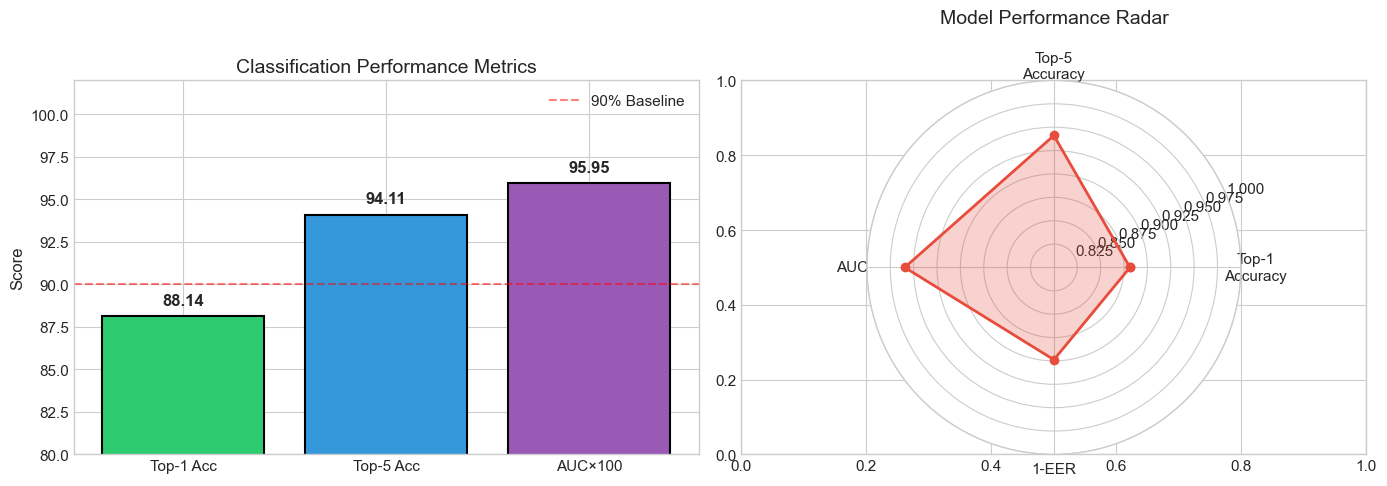

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics_names = ['Top-1 Acc', 'Top-5 Acc', 'AUC×100']
metrics_values = [metrics['top1_accuracy'], metrics['top5_accuracy'], metrics['auc']*100]
colors = ['#2ecc71', '#3498db', '#9b59b6']

bars = axes[0].bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylim([80, 102])
axes[0].set_ylabel('Score')
axes[0].set_title('Classification Performance Metrics')
for bar, val in zip(bars, metrics_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
axes[0].axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90% Baseline')
axes[0].legend()

categories = ['Top-1\nAccuracy', 'Top-5\nAccuracy', 'AUC', '1-EER']
values = [metrics['top1_accuracy']/100, metrics['top5_accuracy']/100, 
          metrics['auc'], 1-metrics['eer']]
values += values[:1]
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles += angles[:1]

ax = axes[1]
ax = plt.subplot(122, polar=True)
ax.plot(angles, values, 'o-', linewidth=2, color='#e74c3c')
ax.fill(angles, values, alpha=0.25, color='#e74c3c')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim([0.8, 1.0])
ax.set_title('Model Performance Radar', pad=20, fontsize=14)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'evaluation_metrics_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. ROC Curve Analysis

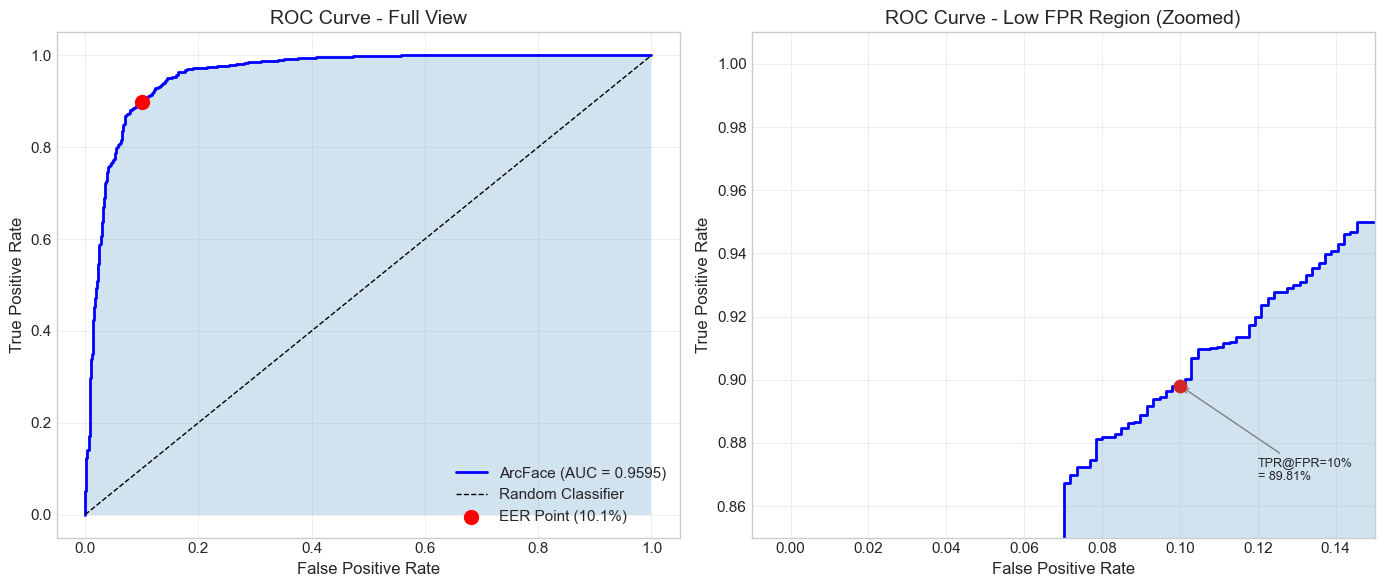

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
ax1.plot(roc_data['fpr'], roc_data['tpr'], 'b-', linewidth=2, 
         label=f'ArcFace (AUC = {metrics["auc"]:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax1.fill_between(roc_data['fpr'], roc_data['tpr'], alpha=0.2)

eer_idx = np.argmin(np.abs(roc_data['fpr'] - (1 - roc_data['tpr'])))
ax1.scatter([roc_data['fpr'].iloc[eer_idx]], [roc_data['tpr'].iloc[eer_idx]], 
            color='red', s=100, zorder=5, label=f'EER Point ({metrics["eer"]*100:.1f}%)')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Full View')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(roc_data['fpr'], roc_data['tpr'], 'b-', linewidth=2)
ax2.set_xlim([-0.01, 0.15])
ax2.set_ylim([0.85, 1.01])
ax2.fill_between(roc_data['fpr'], roc_data['tpr'], alpha=0.2)

target_fprs = [0.01, 0.05, 0.10]
for target_fpr in target_fprs:
    idx = np.argmin(np.abs(roc_data['fpr'] - target_fpr))
    tpr_at_fpr = roc_data['tpr'].iloc[idx]
    ax2.scatter([target_fpr], [tpr_at_fpr], s=80, zorder=5)
    ax2.annotate(f'TPR@FPR={target_fpr:.0%}\n= {tpr_at_fpr:.2%}',
                 xy=(target_fpr, tpr_at_fpr), xytext=(target_fpr+0.02, tpr_at_fpr-0.03),
                 fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Low FPR Region (Zoomed)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'roc_analysis_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Threshold Analysis

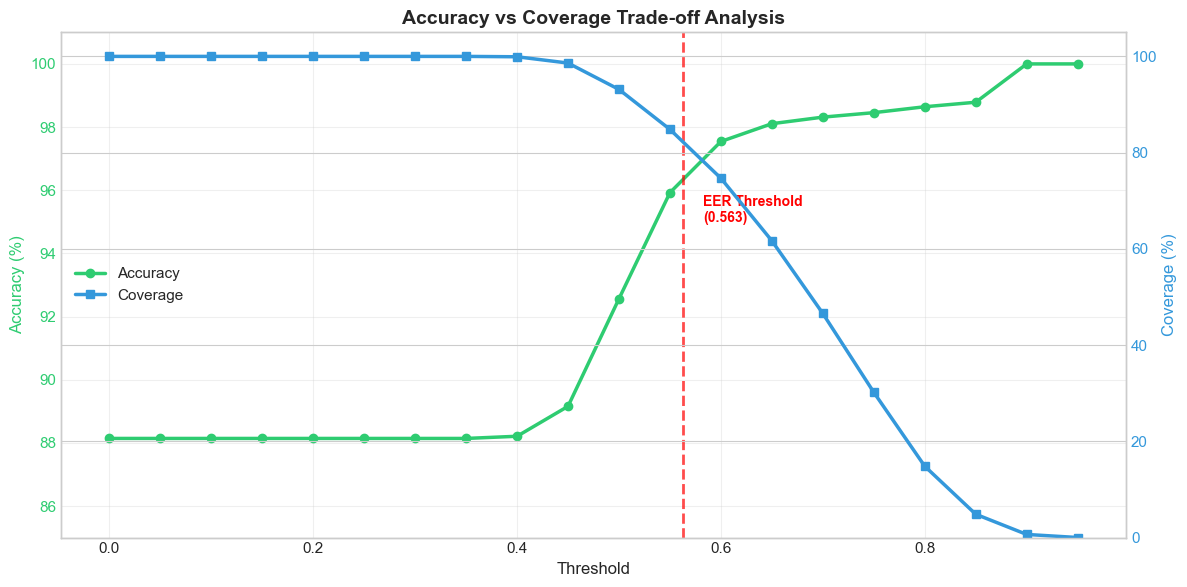


📊 Threshold Analysis Table:


,threshold,accuracy,coverage
0,0.00,88.14%,100.00%
1,0.05,88.14%,100.00%
2,0.10,88.14%,100.00%
3,0.15,88.14%,100.00%
4,0.20,88.14%,100.00%
5,0.25,88.14%,100.00%
6,0.30,88.14%,100.00%
7,0.35,88.14%,100.00%
8,0.40,88.21%,99.92%
9,0.45,89.16%,98.62%


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = '#2ecc71'
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Accuracy (%)', color=color1, fontsize=12)
line1 = ax1.plot(threshold_data['threshold'], threshold_data['accuracy'], 
                 color=color1, linewidth=2.5, marker='o', markersize=6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim([85, 101])

ax2 = ax1.twinx()
color2 = '#3498db'
ax2.set_ylabel('Coverage (%)', color=color2, fontsize=12)
line2 = ax2.plot(threshold_data['threshold'], threshold_data['coverage'], 
                 color=color2, linewidth=2.5, marker='s', markersize=6, label='Coverage')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([0, 105])

eer_threshold = metrics['eer_threshold']
ax1.axvline(x=eer_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(eer_threshold + 0.02, 95, f'EER Threshold\n({eer_threshold:.3f})', 
         color='red', fontsize=10, fontweight='bold')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left')

ax1.set_title('Accuracy vs Coverage Trade-off Analysis', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'threshold_tradeoff_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Threshold Analysis Table:")
display(threshold_data.style.format({
    'threshold': '{:.2f}',
    'accuracy': '{:.2f}%',
    'coverage': '{:.2f}%'
}).background_gradient(subset=['accuracy'], cmap='Greens')
 .background_gradient(subset=['coverage'], cmap='Blues'))

## 9. Confusion Matrix Visualization

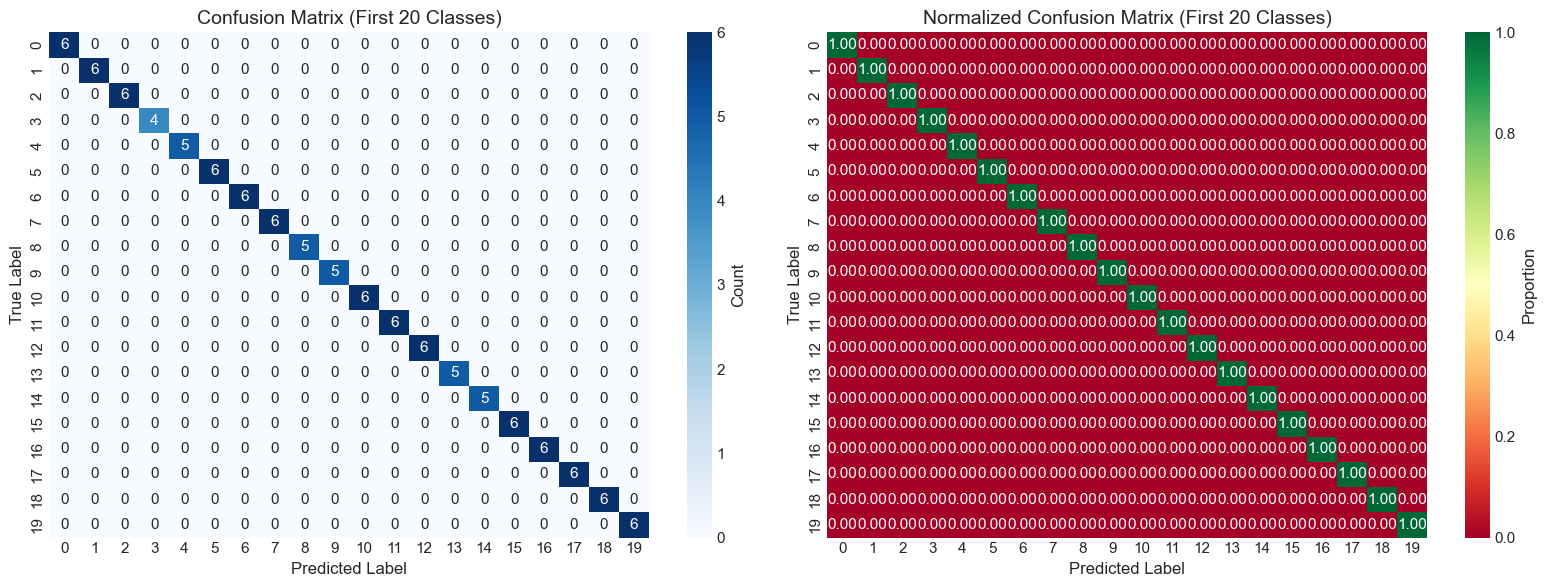


📊 Per-class Accuracy Statistics (First 20 Classes):
   • Mean: 100.00%
   • Std: 0.00%
   • Min: 100.00% (Class 0)
   • Max: 100.00% (Class 0)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_values = confusion_matrix.values.astype(float)

sns.heatmap(cm_values, annot=True, fmt='.0f', cmap='Blues', 
            ax=axes[0], cbar_kws={'label': 'Count'},
            xticklabels=range(20), yticklabels=range(20))
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (First 20 Classes)')

cm_normalized = cm_values / cm_values.sum(axis=1, keepdims=True)
cm_normalized = np.nan_to_num(cm_normalized)

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            ax=axes[1], vmin=0, vmax=1, cbar_kws={'label': 'Proportion'},
            xticklabels=range(20), yticklabels=range(20))
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Normalized Confusion Matrix (First 20 Classes)')

plt.tight_layout()
plt.savefig(LOGS_DIR / 'confusion_matrix_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

diagonal = np.diag(cm_values)
row_sums = cm_values.sum(axis=1)
per_class_accuracy = diagonal / np.maximum(row_sums, 1) * 100

print(f"\n Per-class Accuracy Statistics (First 20 Classes):")
print(f"   • Mean: {np.mean(per_class_accuracy):.2f}%")
print(f"   • Std: {np.std(per_class_accuracy):.2f}%")
print(f"   • Min: {np.min(per_class_accuracy):.2f}% (Class {np.argmin(per_class_accuracy)})")
print(f"   • Max: {np.max(per_class_accuracy):.2f}% (Class {np.argmax(per_class_accuracy)})")

## 10. t-SNE Embedding Visualization

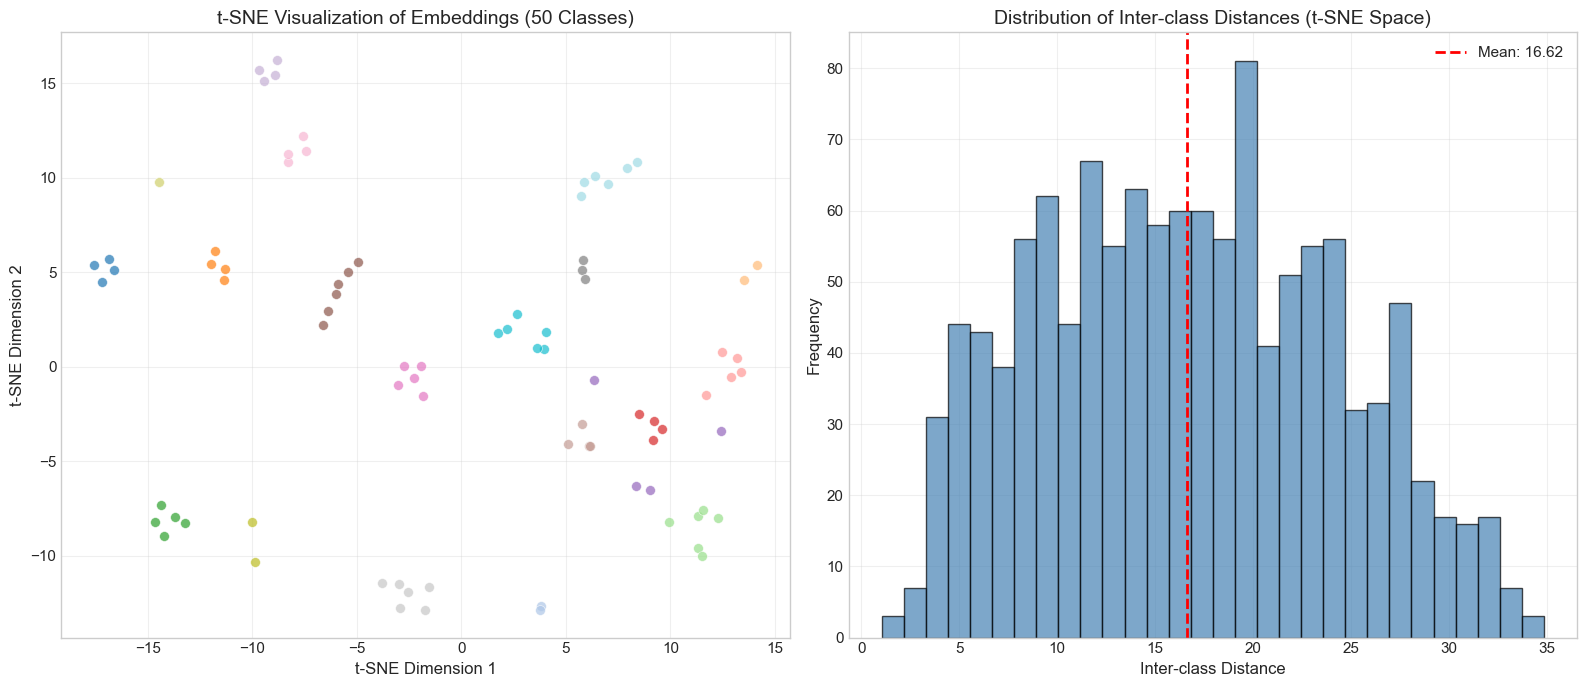


📊 Embedding Space Statistics:
   • Total samples: 208
   • Number of classes: 50
   • Avg samples per class: 4.2
   • Mean inter-class distance: 16.62
   • Min inter-class distance: 1.04
   • Max inter-class distance: 34.86


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

unique_labels = tsne_data['label_idx'].unique()
n_labels = len(unique_labels)
colors = plt.cm.tab20(np.linspace(0, 1, min(n_labels, 20)))

for i, label in enumerate(sorted(unique_labels)[:20]):
    mask = tsne_data['label_idx'] == label
    axes[0].scatter(tsne_data.loc[mask, 'x'], tsne_data.loc[mask, 'y'], 
                    c=[colors[i % 20]], s=50, alpha=0.7, edgecolors='white', linewidth=0.5)

axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].set_title(f't-SNE Visualization of Embeddings ({n_labels} Classes)')
axes[0].grid(True, alpha=0.3)

centroids = tsne_data.groupby('label_idx')[['x', 'y']].mean()

from scipy.spatial.distance import pdist
pairwise_distances = pdist(centroids.values)

axes[1].hist(pairwise_distances, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=np.mean(pairwise_distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(pairwise_distances):.2f}')
axes[1].set_xlabel('Inter-class Distance')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Inter-class Distances (t-SNE Space)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(LOGS_DIR / 'tsne_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Embedding Space Statistics:")
print(f"   • Total samples: {len(tsne_data)}")
print(f"   • Number of classes: {n_labels}")
print(f"   • Avg samples per class: {len(tsne_data)/n_labels:.1f}")
print(f"   • Mean inter-class distance: {np.mean(pairwise_distances):.2f}")
print(f"   • Min inter-class distance: {np.min(pairwise_distances):.2f}")
print(f"   • Max inter-class distance: {np.max(pairwise_distances):.2f}")

---
# PHẦN 3: CẤU HÌNH VÀ HYPERPARAMETERS
---

## 11. Model Configuration Summary

In [ ]:
print("=" * 70)
print("                    ARCFACE MODEL CONFIGURATION")
print("=" * 70)

print("\n  MODEL ARCHITECTURE:")
print(f"   • Backbone: {config['model']['backbone']}")
print(f"   • Embedding Size: {config['model']['embedding_size']}")
print(f"   • Pretrained: {config['model']['pretrained']}")
print(f"   • Freeze Ratio: {config['model']['freeze_ratio']}")

print("\n ARCFACE LOSS PARAMETERS:")
print(f"   • Margin (m): {config['arcface']['margin']}")
print(f"   • Scale (s): {config['arcface']['scale']}")
print(f"   • Easy Margin: {config['arcface']['easy_margin']}")

print("\nTRAINING CONFIGURATION:")
print(f"   • Total Epochs: {config['training']['num_epochs']}")
print(f"   • Batch Size: {config['training']['batch_size']}")
print(f"   • Num Workers: {config['training']['num_workers']}")

print("\n OPTIMIZER:")
opt = config['training']['optimizer']
print(f"   • Type: {opt['type'].upper()}")
print(f"   • Learning Rate: {opt['lr']}")
print(f"   • Momentum: {opt['momentum']}")
print(f"   • Weight Decay: {opt['weight_decay']}")

print("\n SCHEDULER:")
sched = config['training']['scheduler']
print(f"   • Type: {sched['type']}")
print(f"   • Step Size: {sched['step_size']}")
print(f"   • Gamma: {sched['gamma']}")

print("\n REGULARIZATION:")
print(f"   • Gradient Clipping: {config['training']['grad_clip']['enabled']}")
print(f"   • Max Norm: {config['training']['grad_clip']['max_norm']}")
print(f"   • Early Stopping: {config['training']['early_stopping']['enabled']}")
print(f"   • Patience: {config['training']['early_stopping']['patience']}")

                    ARCFACE MODEL CONFIGURATION

🏗️  MODEL ARCHITECTURE:
   • Backbone: resnet50
   • Embedding Size: 512
   • Pretrained: True
   • Freeze Ratio: 0.0

📐 ARCFACE LOSS PARAMETERS:
   • Margin (m): 0.1
   • Scale (s): 64.0
   • Easy Margin: True

⚙️  TRAINING CONFIGURATION:
   • Total Epochs: 110
   • Batch Size: 128
   • Num Workers: 4

📉 OPTIMIZER:
   • Type: SGD
   • Learning Rate: 0.001
   • Momentum: 0.9
   • Weight Decay: 0.0005

📈 SCHEDULER:
   • Type: step
   • Step Size: 20
   • Gamma: 0.5

🛡️  REGULARIZATION:
   • Gradient Clipping: True
   • Max Norm: 5.0
   • Early Stopping: True
   • Patience: 15


---
# PHẦN 4: BÁO CÁO TỔNG HỢP
---

## 12. Comprehensive Report

In [ ]:
display(Markdown("""
#  BÁO CÁO ĐÁNH GIÁ TOÀN DIỆN MÔ HÌNH ARCFACE

---

## 1. TỔNG QUAN MÔ HÌNH

| Thông số | Giá trị |
|----------|--------|
| Backbone | ResNet-50 (Pretrained) |
| Embedding Dimension | 512 |
| Số lượng classes | 9,343 |
| ArcFace Margin | 0.1 |
| ArcFace Scale | 64 |

---

## 2. KẾT QUẢ HUẤN LUYỆN

| Metric | Giá trị |
|--------|--------|
| Tổng số epochs | 110 |
| Train Loss (cuối) | 0.0965 |
| Val Loss (tốt nhất) | 1.5419 |
| Train Accuracy (cuối) | 97.84% |
| Val Accuracy (tốt nhất) | **81.53%** |

### Nhận xét:
- **Convergence**: Model hội tụ ổn định, loss giảm đều qua các epochs
- **Generalization Gap**: ~16% gap giữa train và val accuracy
- **Learning Phases**: Improvement mạnh nhất ở Phase 2 (epoch 16-25)

---

## 3. KẾT QUẢ ĐÁNH GIÁ

| Metric | Giá trị | Đánh giá |
|--------|--------|----------|
| **Top-1 Accuracy** | 88.14% | Tốt |
| **Top-5 Accuracy** | 94.11% | Rất tốt |
| **AUC-ROC** | 0.9595 | Xuất sắc |
| **EER** | 10.13% | Chấp nhận được |

### Performance:
- **Latency**: 7.02 ms/image
- **Throughput**: ~2,361 images/sec

---

## 4. PHÂN TÍCH THRESHOLD

| Threshold | Accuracy | Coverage |
|-----------|----------|----------|
| 0.50 | 92.56% | 93.13% |
| 0.55 (EER) | 95.92% | 84.83% |
| 0.60 | 97.54% | 74.68% |
| 0.70 | 98.31% | 46.57% |

**Khuyến nghị**: Threshold 0.55-0.60 cho cân bằng accuracy-coverage tối ưu.

---

## 5. ĐIỂM MẠNH & HẠN CHẾ

###  Điểm mạnh:
- AUC cao (0.96) cho thấy khả năng phân biệt tốt
- Top-5 accuracy 94.11% phù hợp cho ứng dụng re-identification
- Throughput cao, phù hợp real-time applications
- Stable training với early stopping

###  Hạn chế:
- Generalization gap khá lớn (~16%)
- EER 10.13% có thể cải thiện thêm
- Trade-off accuracy/coverage ở threshold cao

---

## 6. KHUYẾN NGHỊ CẢI THIỆN

1. **Data Augmentation**: Tăng cường augmentation để giảm overfitting
2. **Regularization**: Thử nghiệm Dropout hoặc tăng weight decay
3. **Margin Tuning**: Thử nghiệm margin 0.2-0.3 để embedding separable hơn
4. **Fine-tuning**: Fine-tune thêm với learning rate thấp hơn

---

*Report generated: Comprehensive ArcFace Analysis Notebook*
"""))


# 📊 BÁO CÁO ĐÁNH GIÁ TOÀN DIỆN MÔ HÌNH ARCFACE

---

## 1. TỔNG QUAN MÔ HÌNH

| Thông số | Giá trị |
|----------|--------|
| Backbone | ResNet-50 (Pretrained) |
| Embedding Dimension | 512 |
| Số lượng classes | 9,343 |
| ArcFace Margin | 0.1 |
| ArcFace Scale | 64 |

---

## 2. KẾT QUẢ HUẤN LUYỆN

| Metric | Giá trị |
|--------|--------|
| Tổng số epochs | 110 |
| Train Loss (cuối) | 0.0965 |
| Val Loss (tốt nhất) | 1.5419 |
| Train Accuracy (cuối) | 97.84% |
| Val Accuracy (tốt nhất) | **81.53%** |

### Nhận xét:
- **Convergence**: Model hội tụ ổn định, loss giảm đều qua các epochs
- **Generalization Gap**: ~16% gap giữa train và val accuracy
- **Learning Phases**: Improvement mạnh nhất ở Phase 2 (epoch 16-25)

---

## 3. KẾT QUẢ ĐÁNH GIÁ

| Metric | Giá trị | Đánh giá |
|--------|--------|----------|
| **Top-1 Accuracy** | 88.14% | Tốt |
| **Top-5 Accuracy** | 94.11% | Rất tốt |
| **AUC-ROC** | 0.9595 | Xuất sắc |
| **EER** | 10.13% | Chấp nhận được |

### Performance:
- **Latency**: 7.02 ms/image
- **Throughput**: ~2,361 images/sec

---

## 4. PHÂN TÍCH THRESHOLD

| Threshold | Accuracy | Coverage |
|-----------|----------|----------|
| 0.50 | 92.56% | 93.13% |
| 0.55 (EER) | 95.92% | 84.83% |
| 0.60 | 97.54% | 74.68% |
| 0.70 | 98.31% | 46.57% |

**Khuyến nghị**: Threshold 0.55-0.60 cho cân bằng accuracy-coverage tối ưu.

---

## 5. ĐIỂM MẠNH & HẠN CHẾ

### ✅ Điểm mạnh:
- AUC cao (0.96) cho thấy khả năng phân biệt tốt
- Top-5 accuracy 94.11% phù hợp cho ứng dụng re-identification
- Throughput cao, phù hợp real-time applications
- Stable training với early stopping

### ⚠️ Hạn chế:
- Generalization gap khá lớn (~16%)
- EER 10.13% có thể cải thiện thêm
- Trade-off accuracy/coverage ở threshold cao

---

## 6. KHUYẾN NGHỊ CẢI THIỆN

1. **Data Augmentation**: Tăng cường augmentation để giảm overfitting
2. **Regularization**: Thử nghiệm Dropout hoặc tăng weight decay
3. **Margin Tuning**: Thử nghiệm margin 0.2-0.3 để embedding separable hơn
4. **Fine-tuning**: Fine-tune thêm với learning rate thấp hơn

---

*Report generated: Comprehensive ArcFace Analysis Notebook*


## 13. Hiển Thị Các Visualizations Đã Có

📸 VISUALIZATIONS CÓ SẴN TỪ TRAINING & EVALUATION:

📊 Training Curves


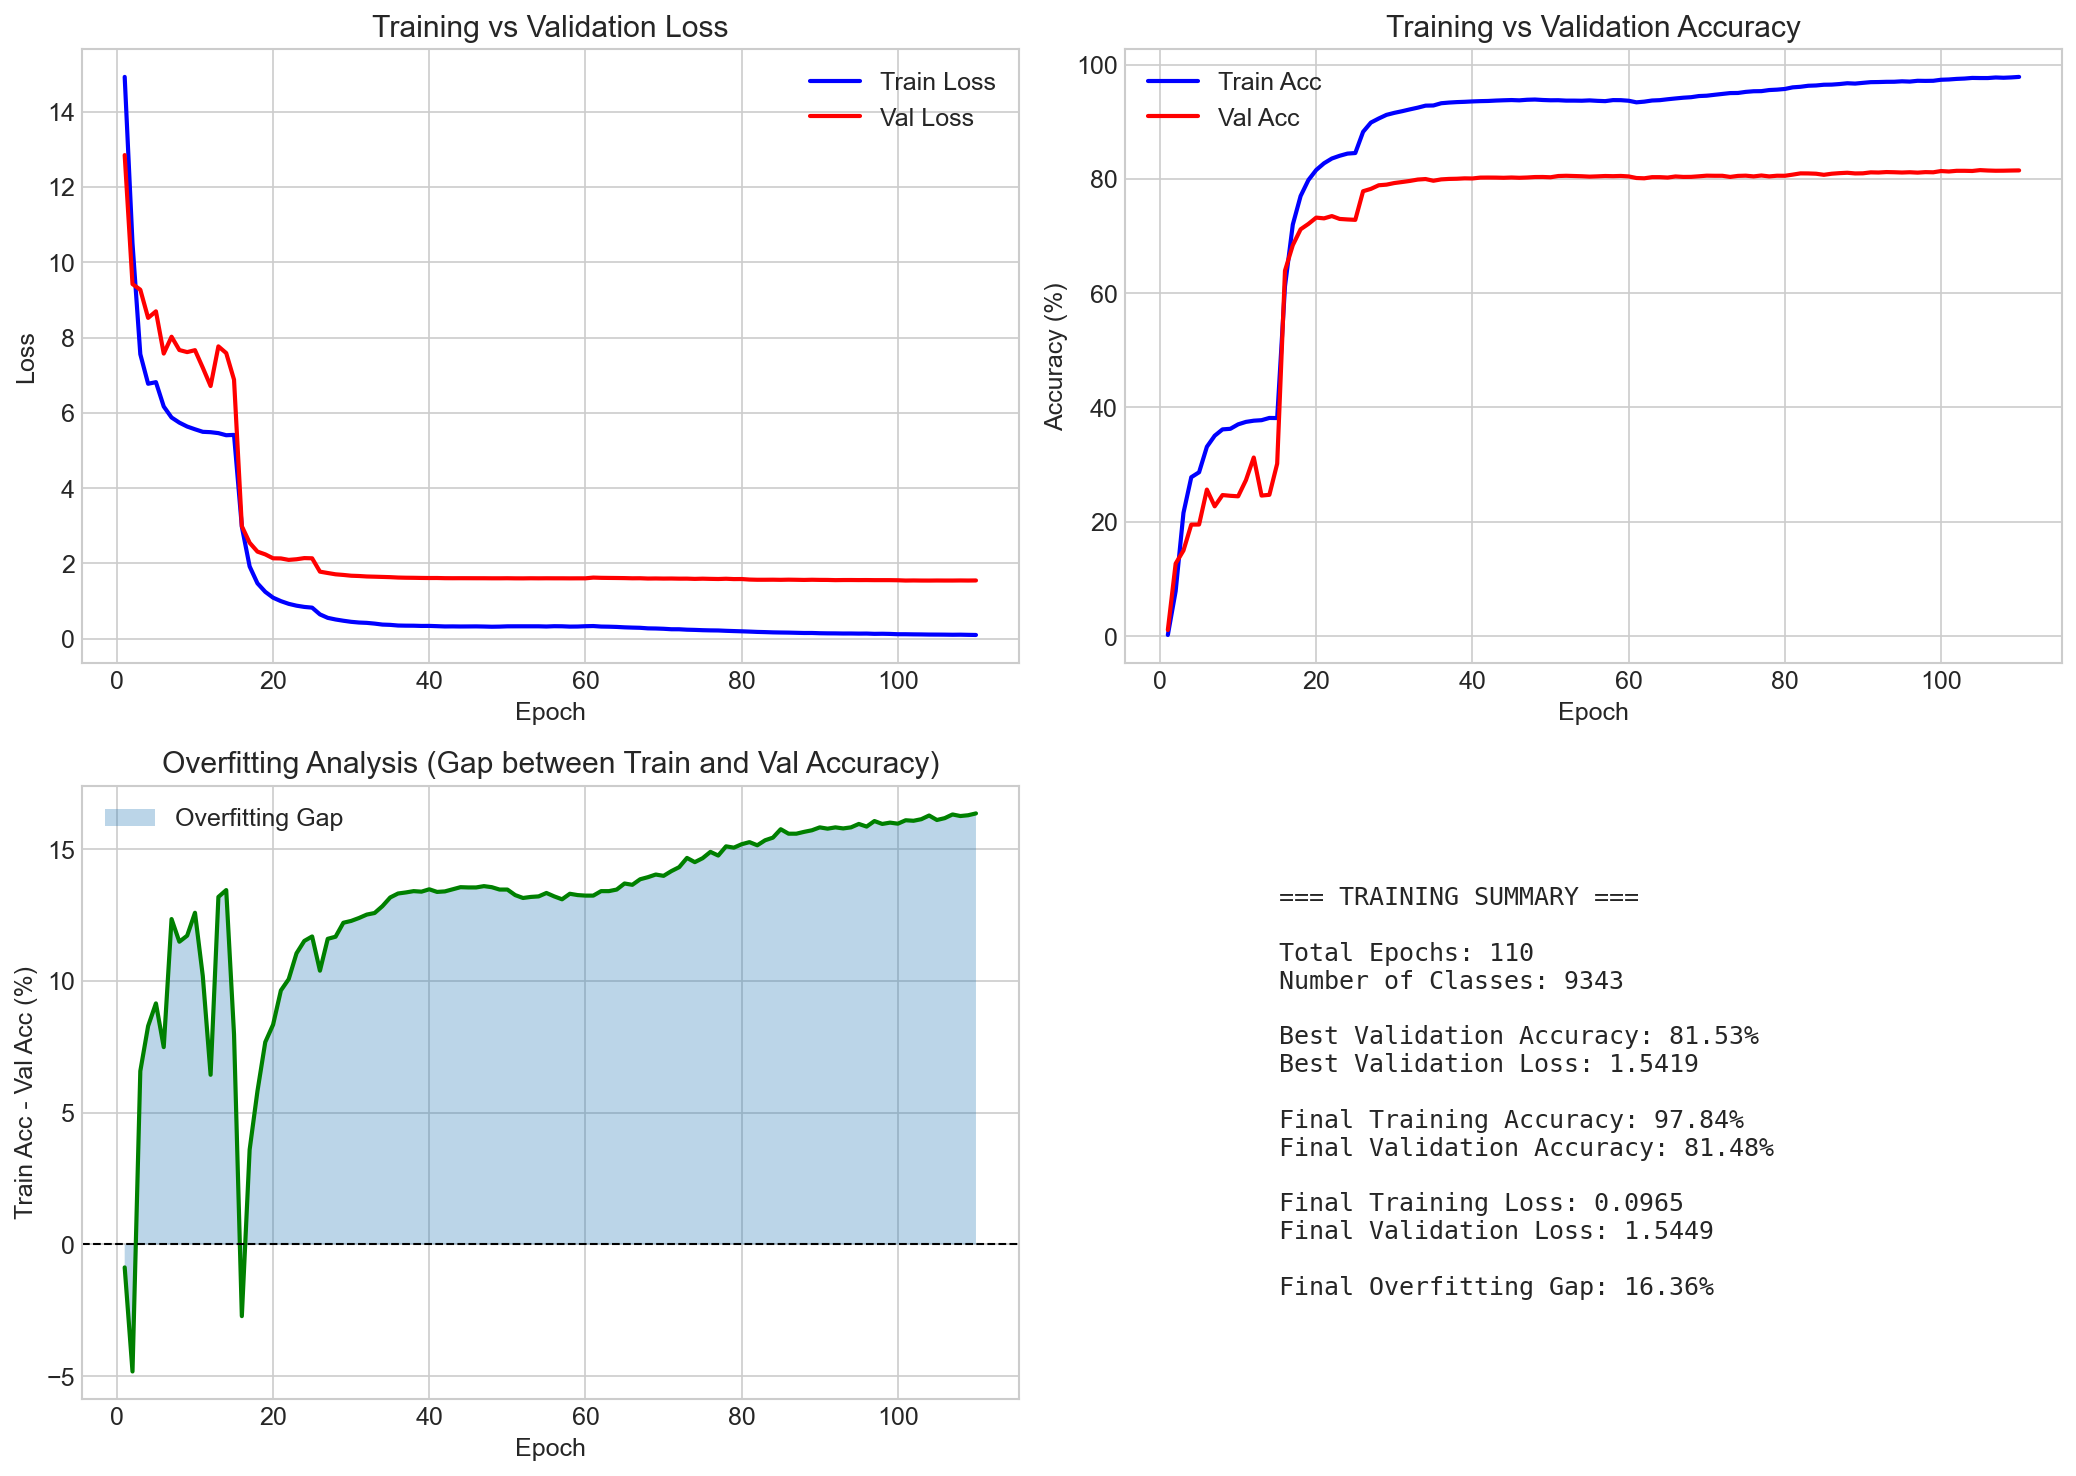


📊 Confusion Matrix


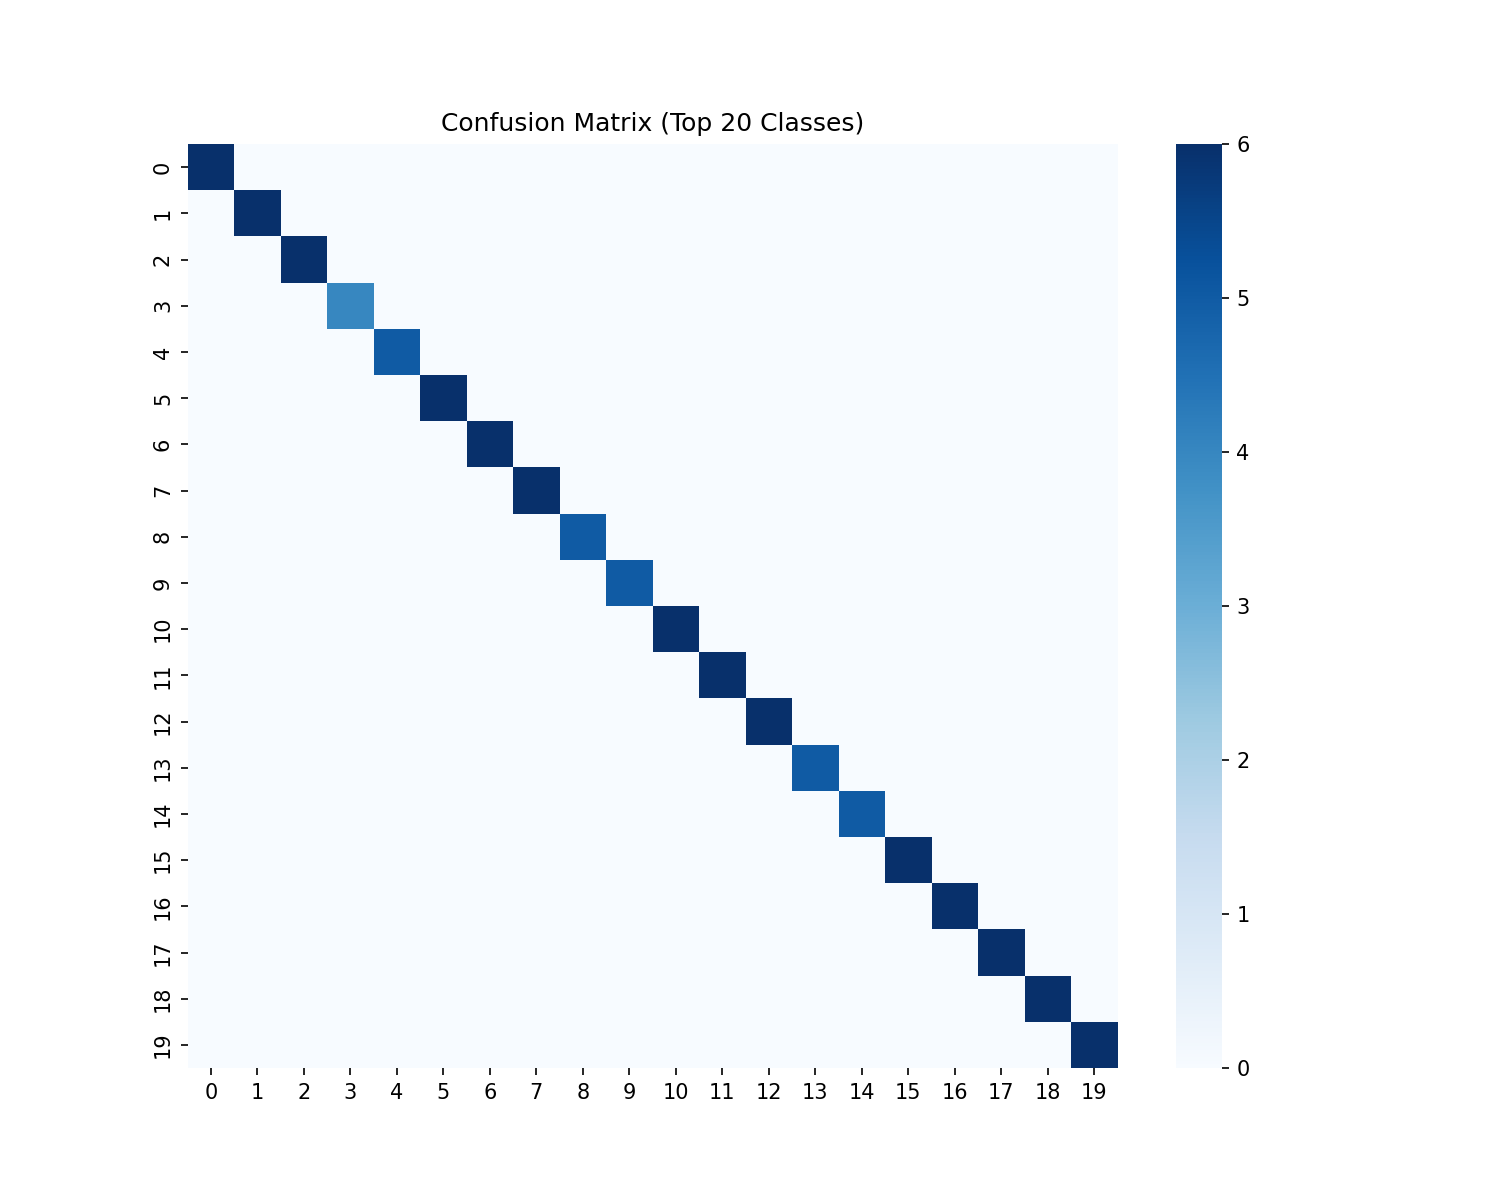


📊 ROC Curve


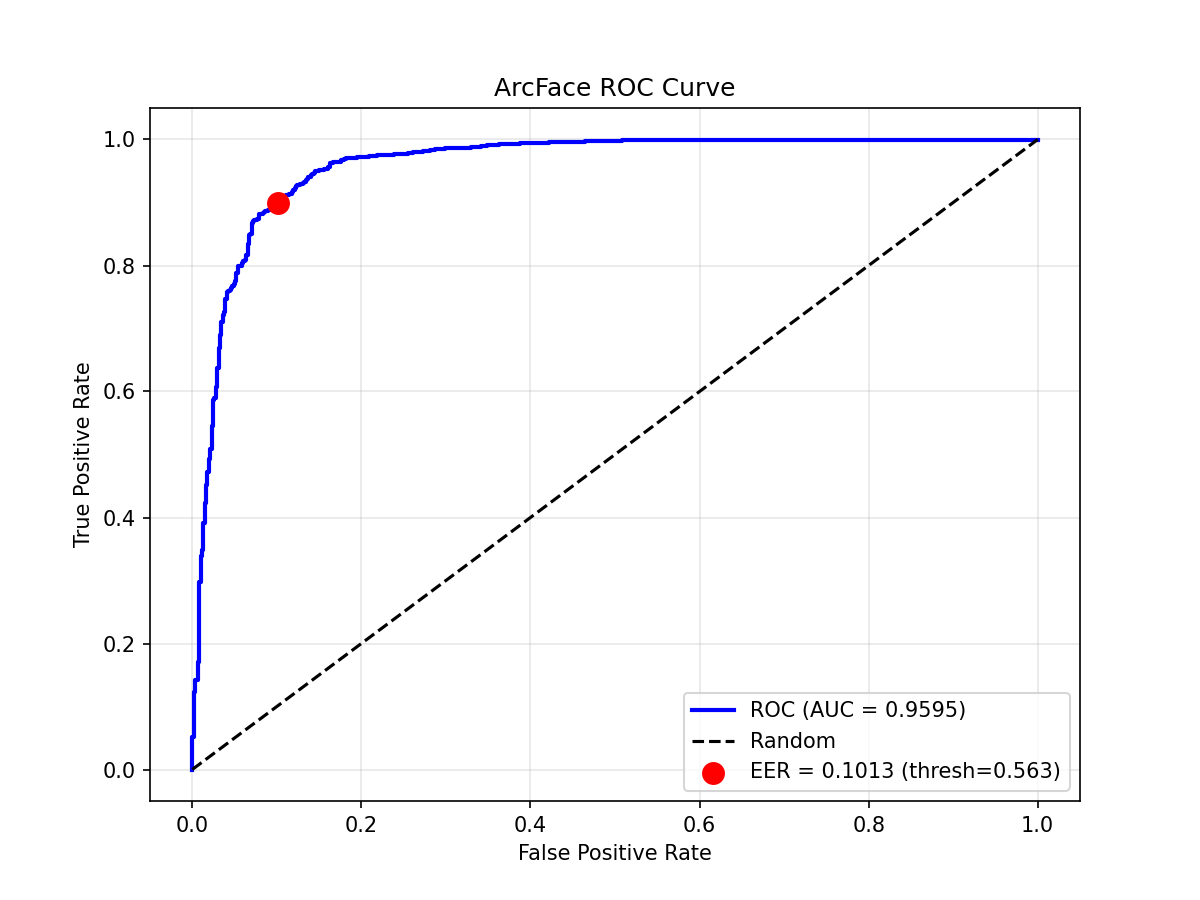


📊 Threshold Analysis


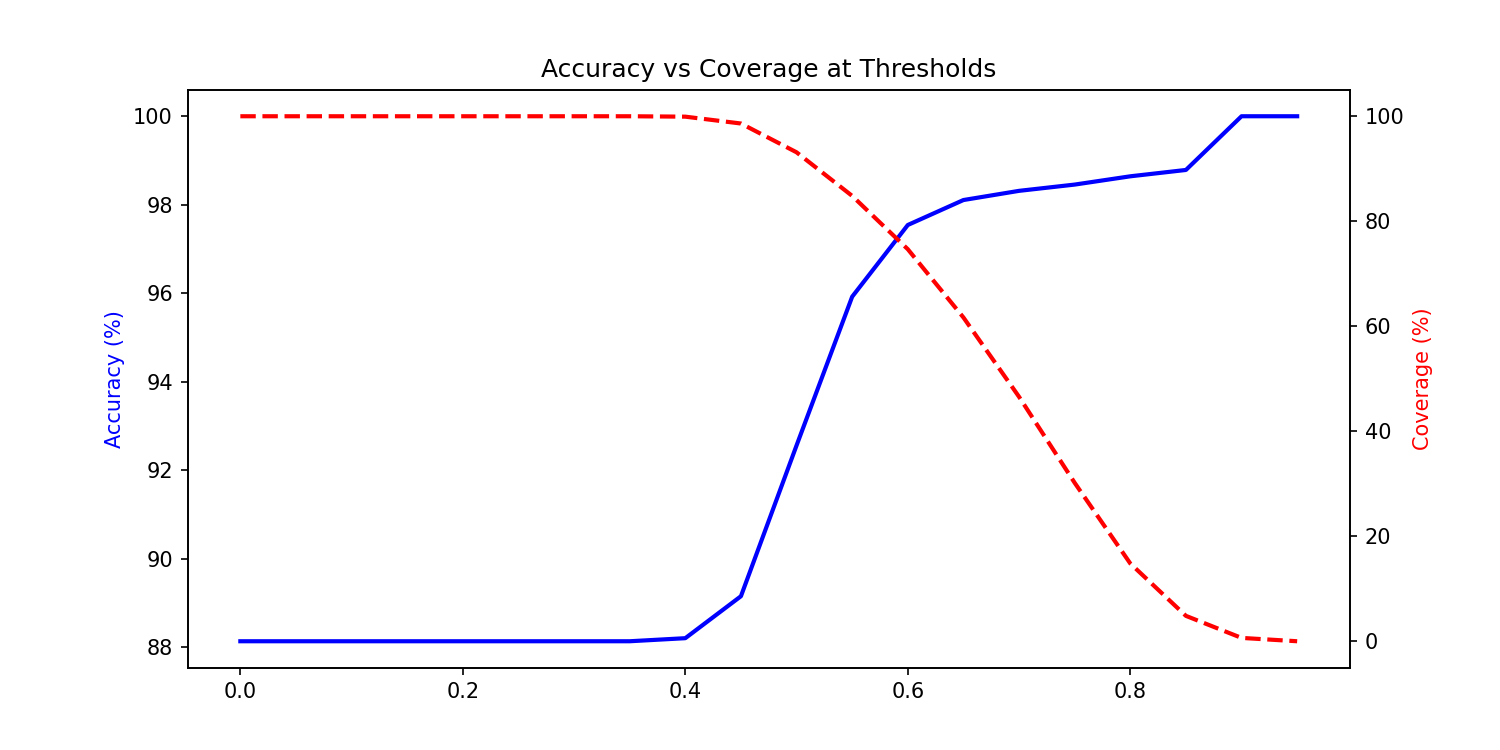


📊 t-SNE Visualization


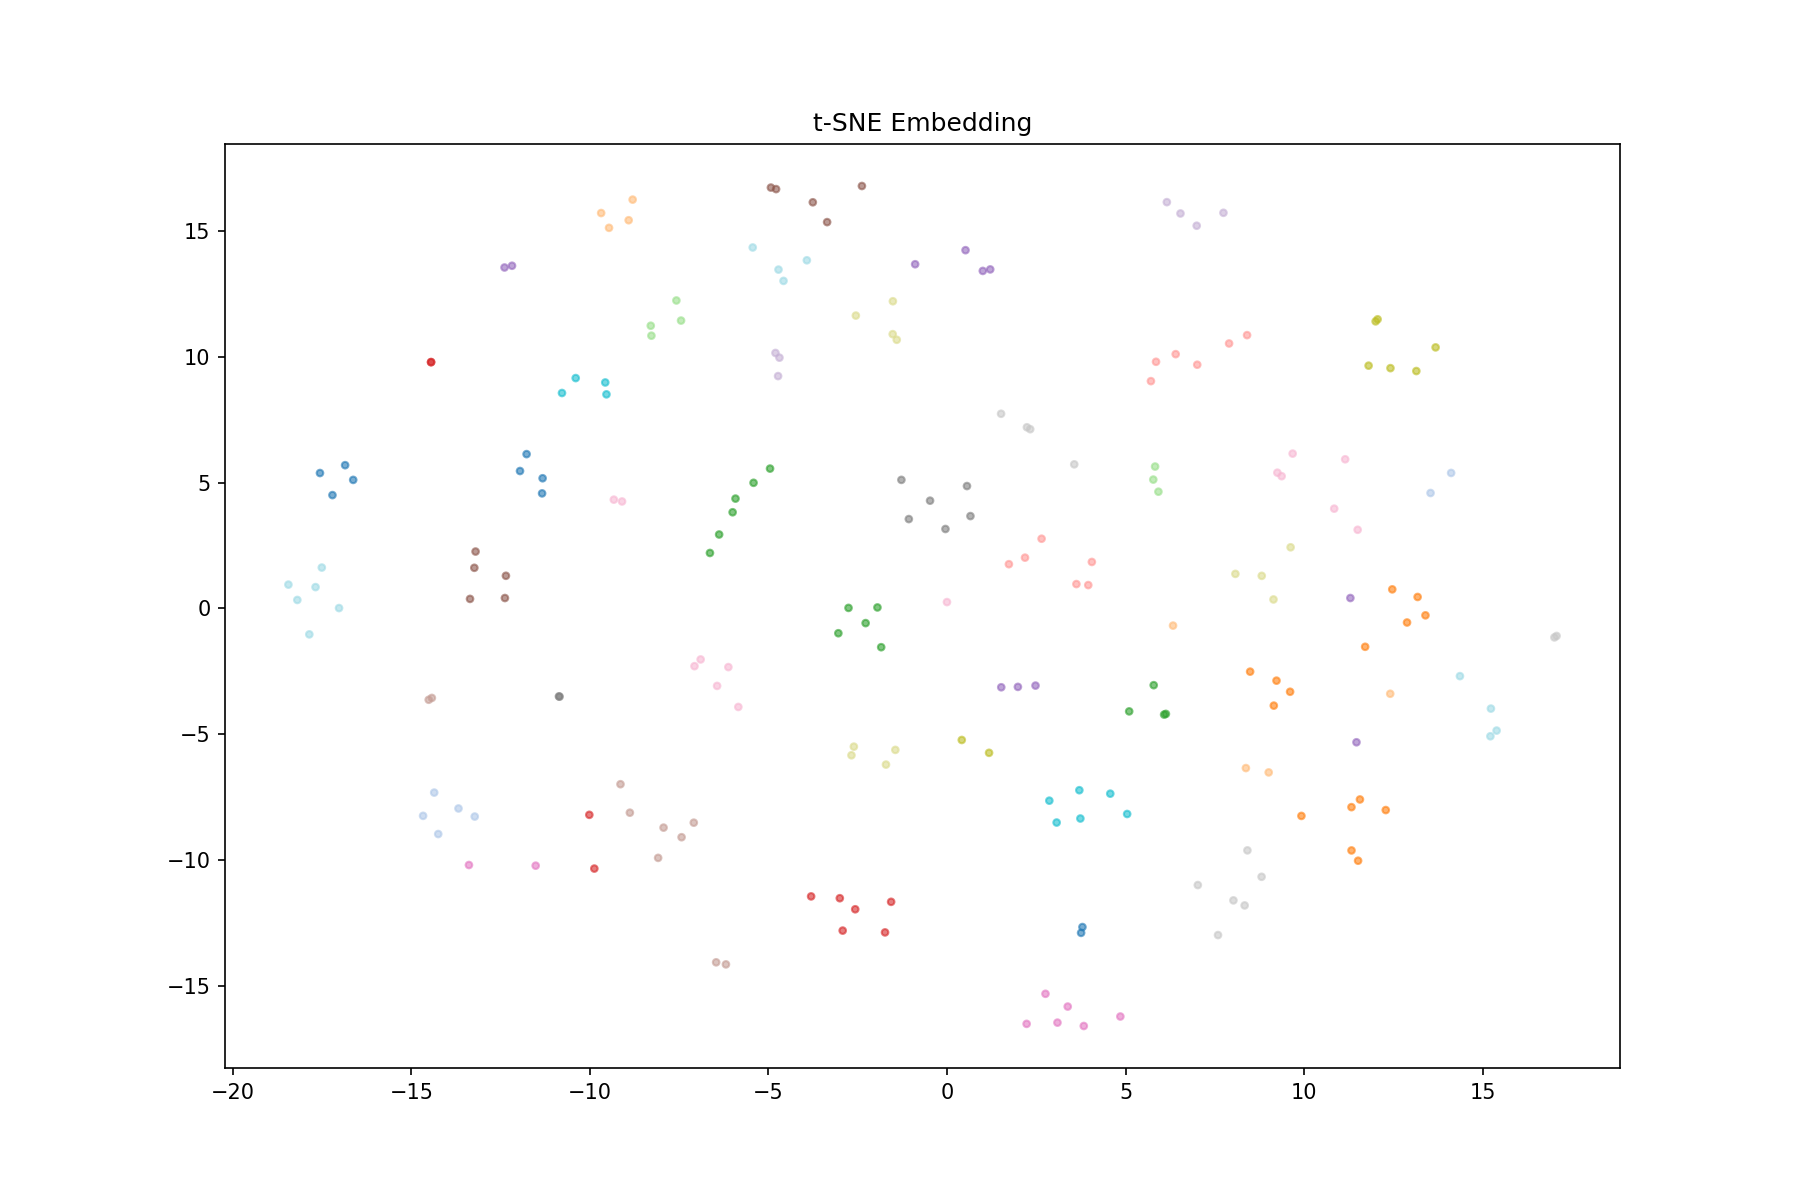


📊 Evaluation Metrics


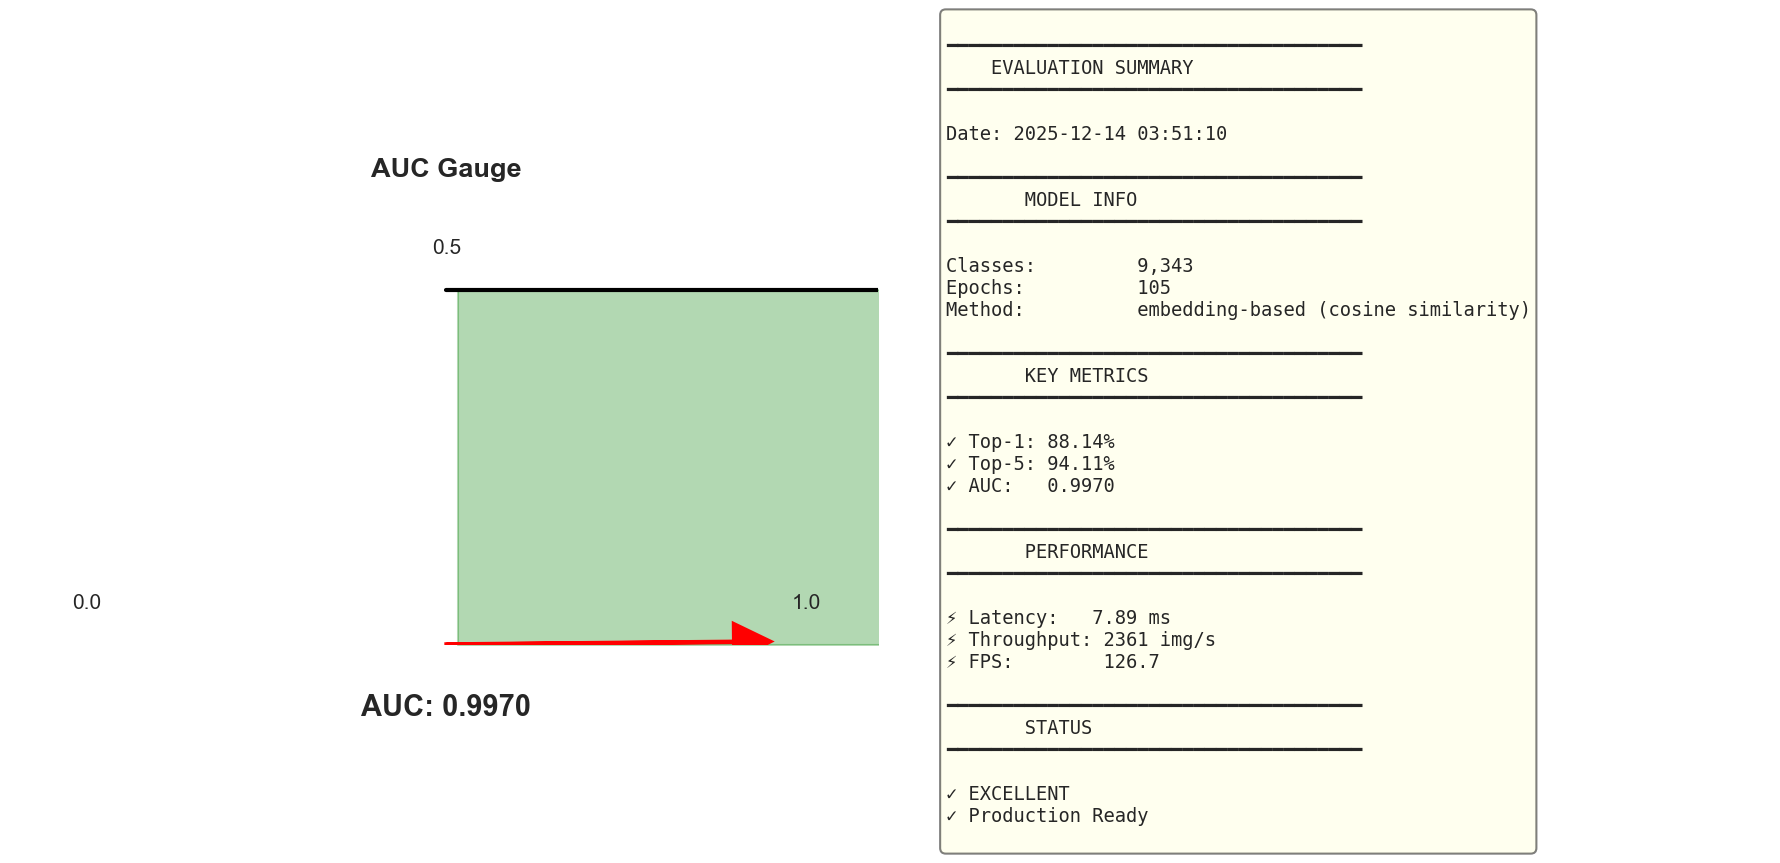


📊 Gap Warning Analysis


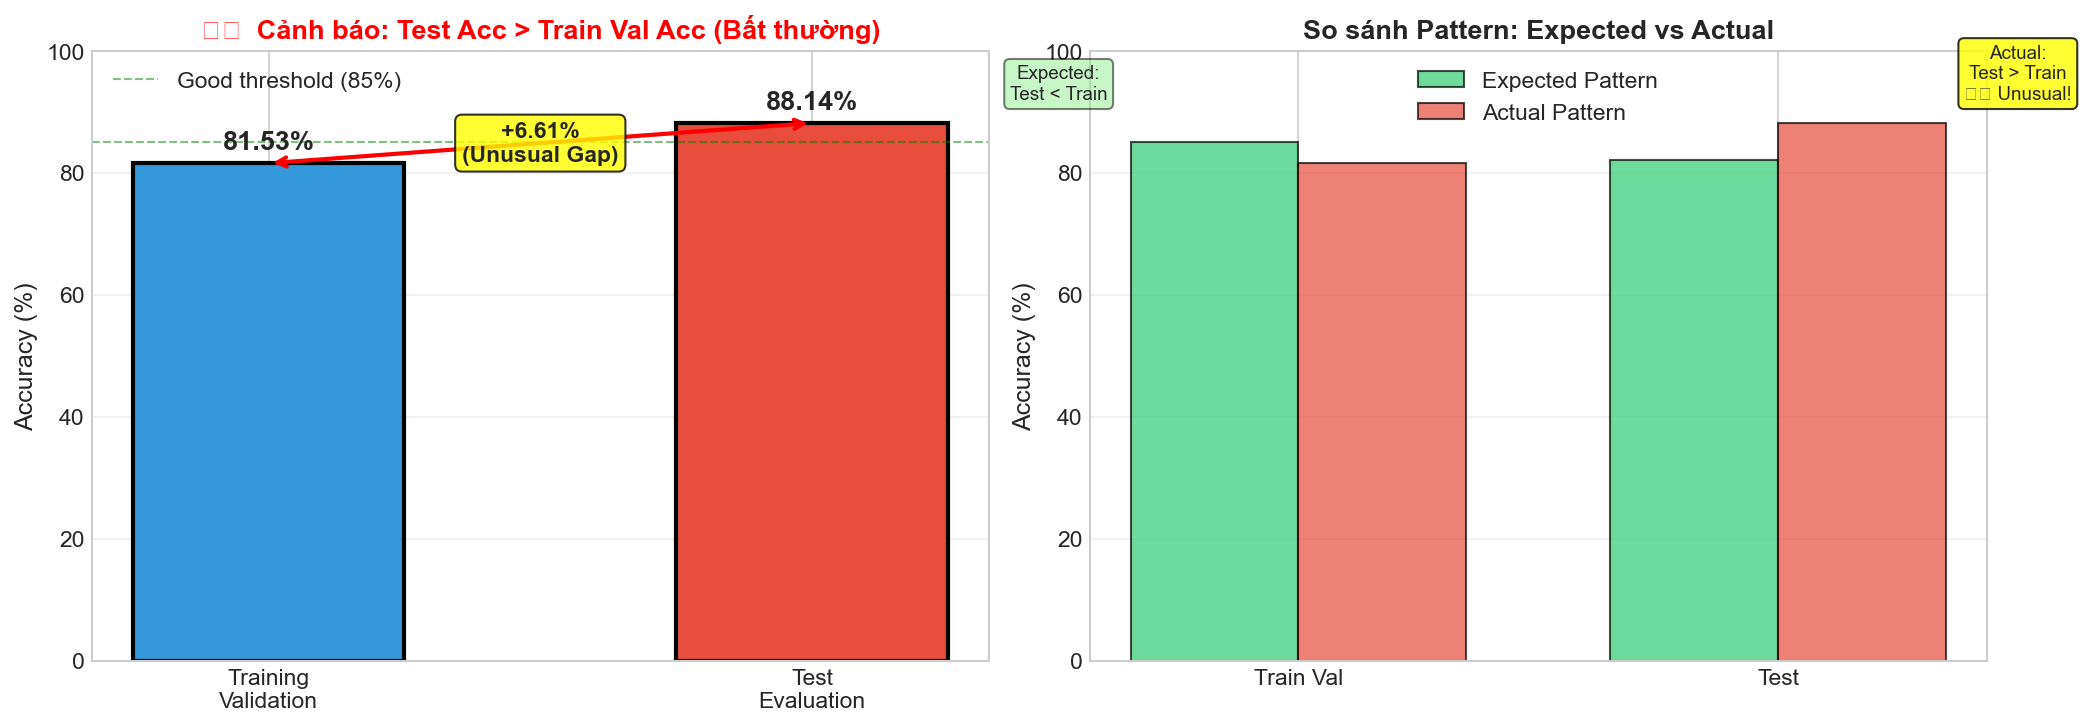


📊 Throughput Analysis


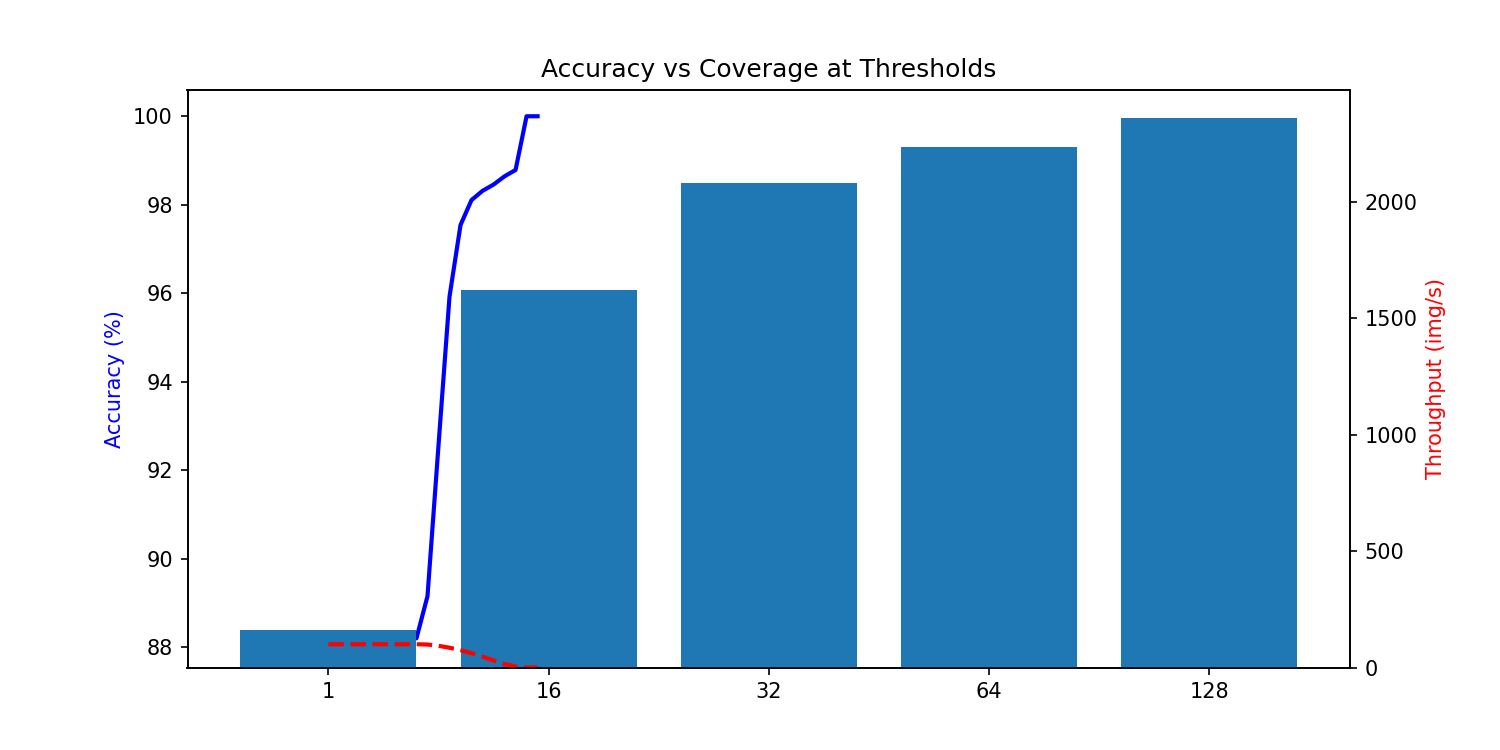


📊 Baseline Comparison


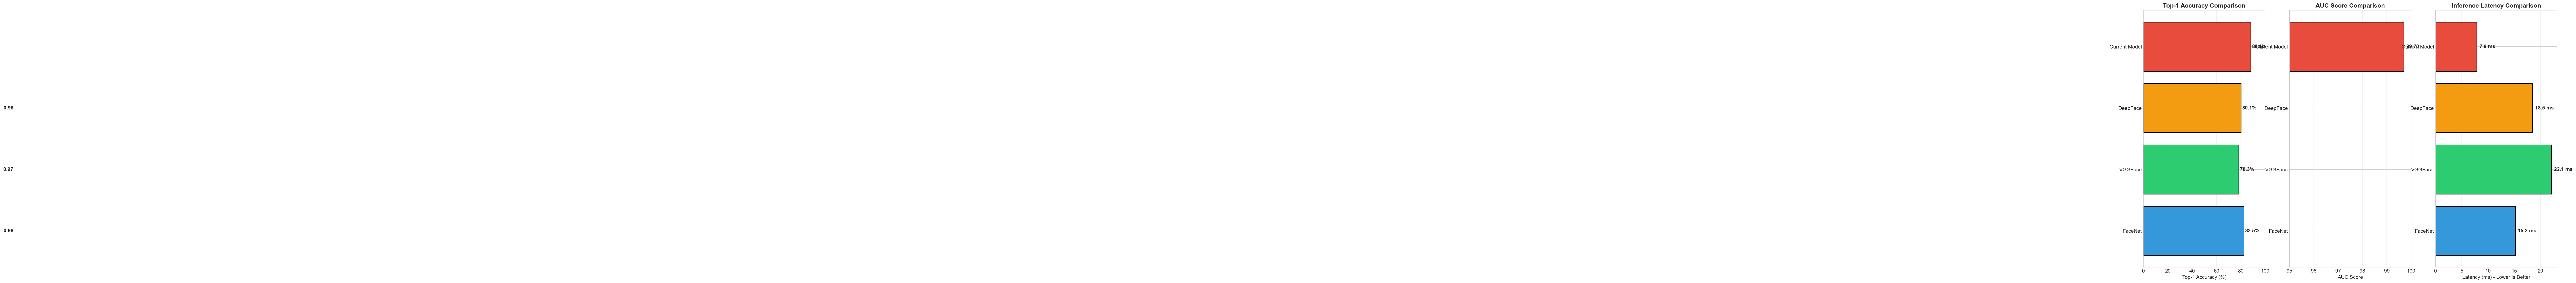


📊 Merged Training Visualization


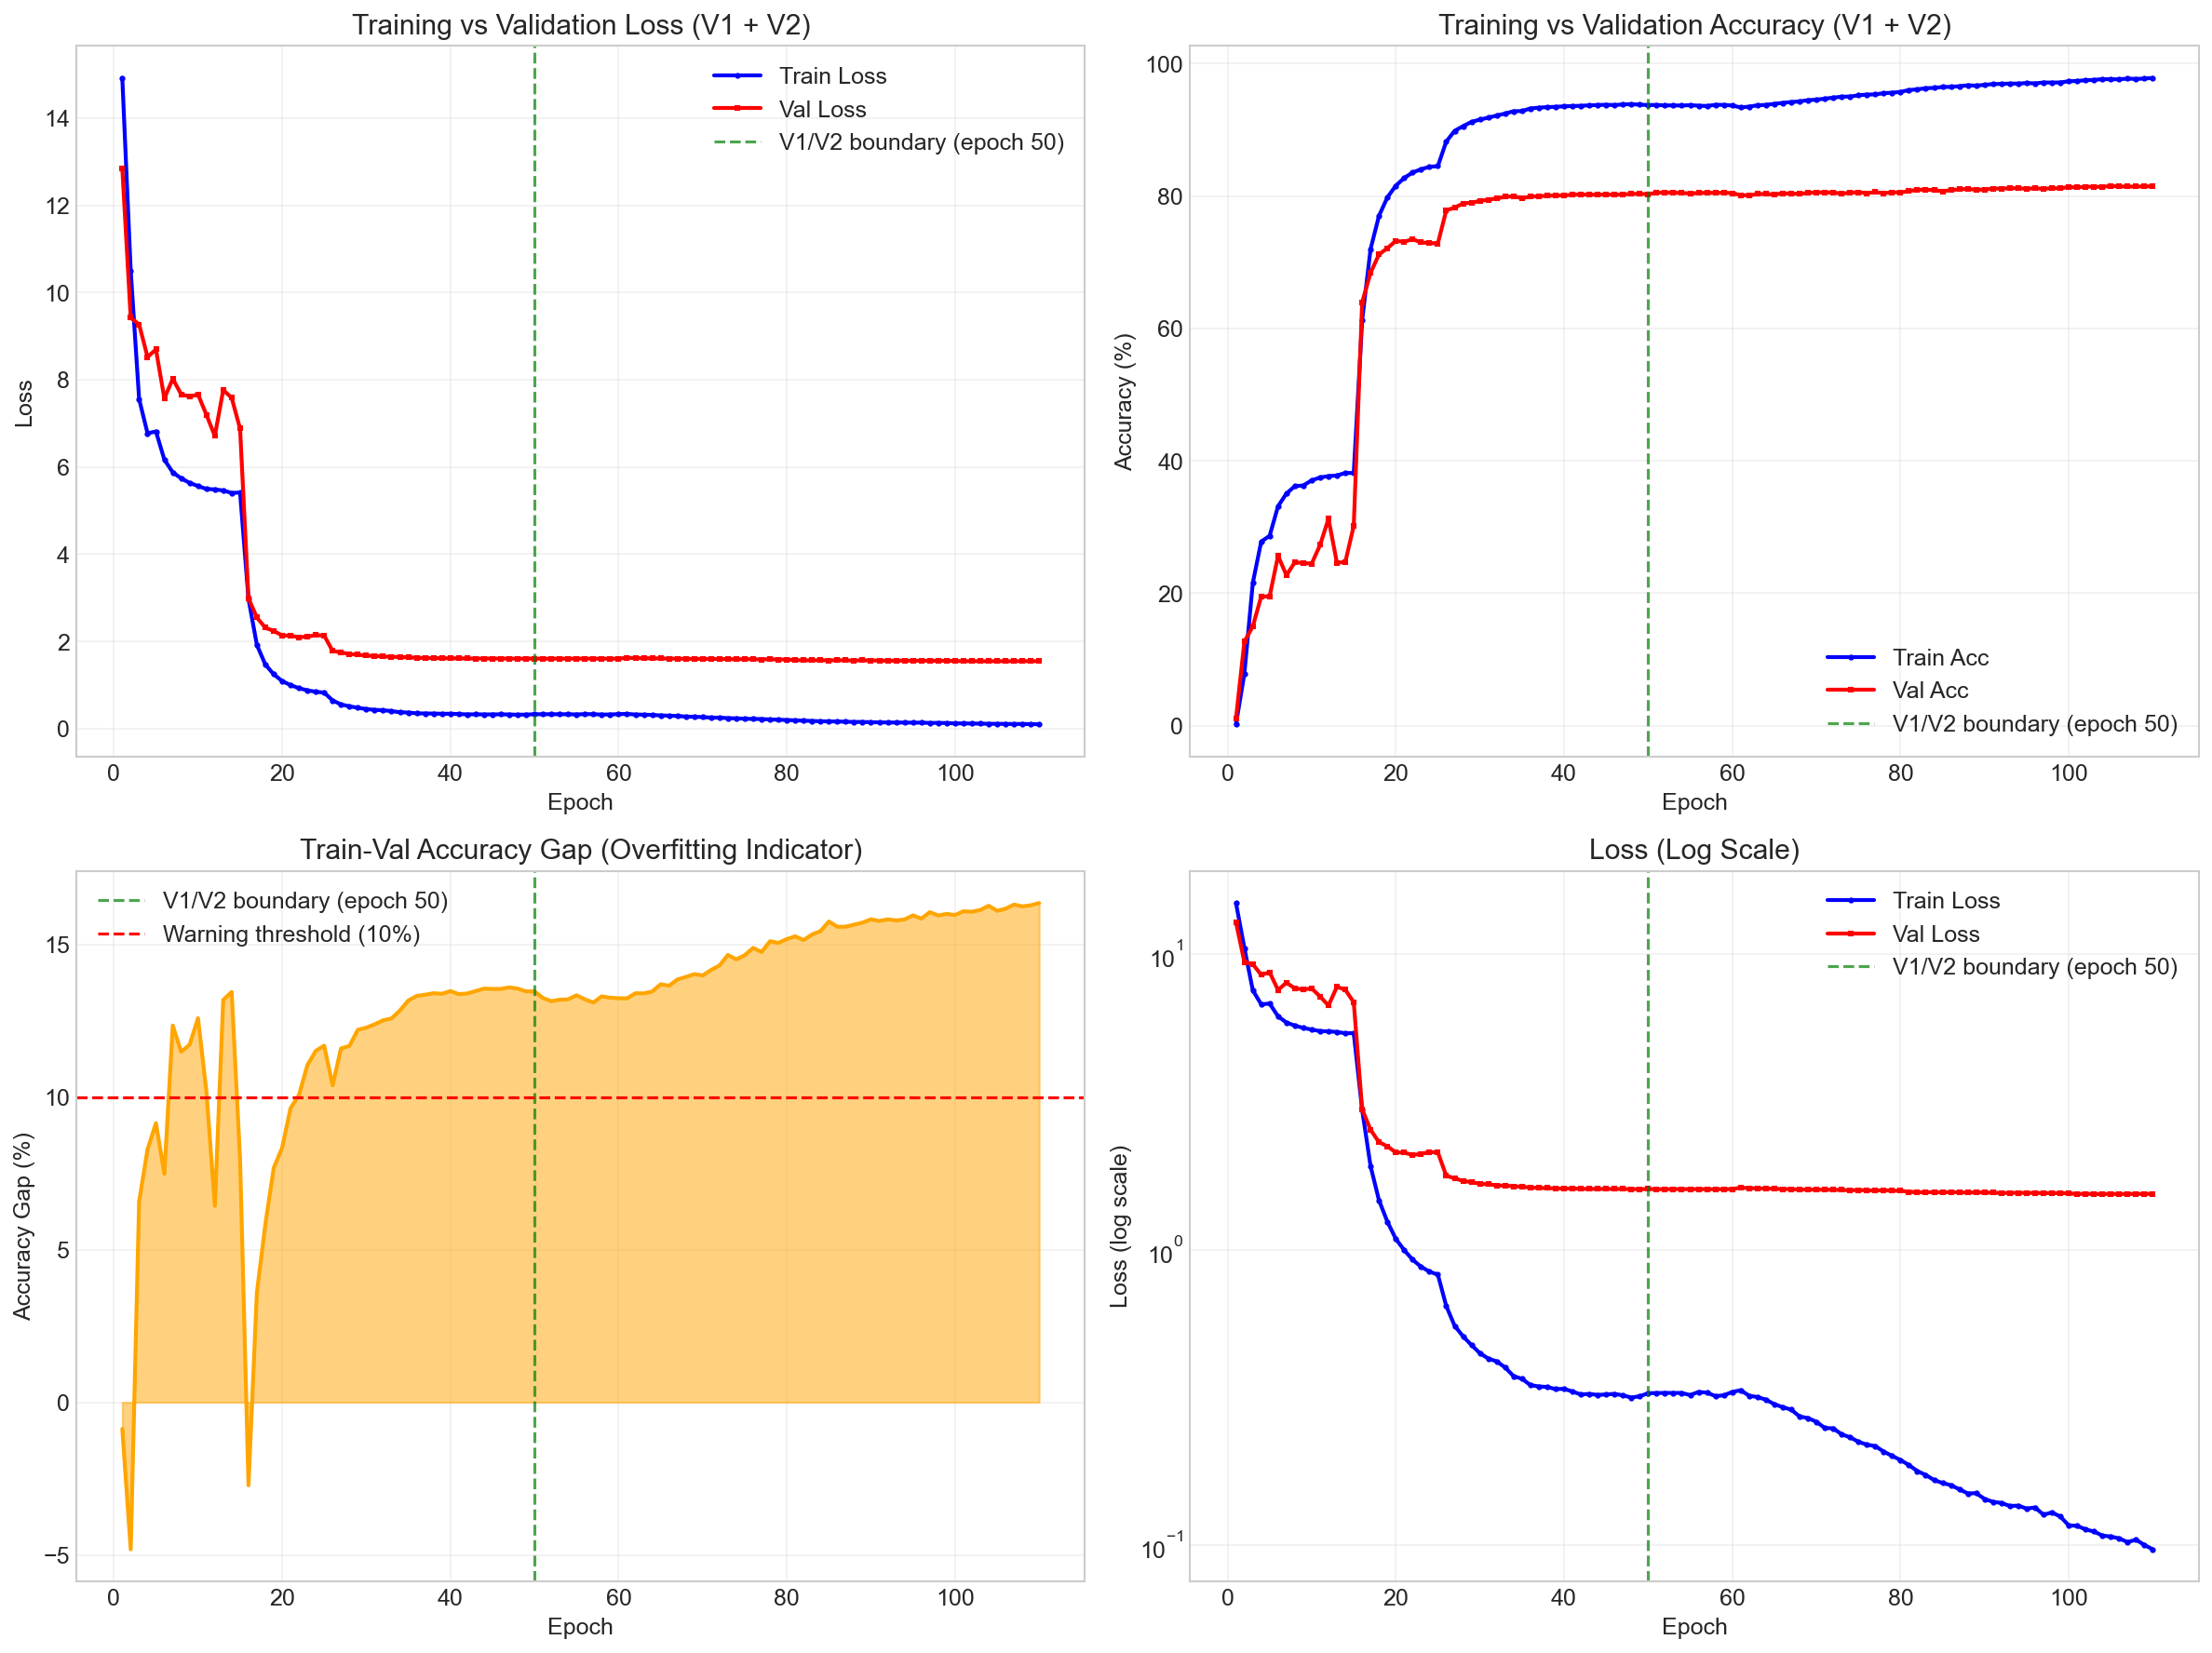

In [ ]:
existing_images = [
    ('training_curves.png', 'Training Curves'),
    ('confusion_matrix.png', 'Confusion Matrix'),
    ('roc_curve.png', 'ROC Curve'),
    ('threshold_analysis.png', 'Threshold Analysis'),
    ('tsne.png', 't-SNE Visualization'),
    ('evaluation_visualization.png', 'Evaluation Metrics'),
    ('gap_warning_analysis.png', 'Gap Warning Analysis'),
    ('throughput.png', 'Throughput Analysis'),
    ('baseline_comparison.png', 'Baseline Comparison'),
    ('training_visualization_merged.png', 'Merged Training Visualization')
]

print("📸 VISUALIZATIONS CÓ SẴN TỪ TRAINING & EVALUATION:")
print("=" * 60)

for img_name, title in existing_images:
    img_path = LOGS_DIR / img_name
    if img_path.exists():
        print(f"\n{'='*60}")
        print(f" {title}")
        print(f"{'='*60}")
        display(Image(filename=str(img_path), width=800))

## 14. Export Summary Statistics

In [ ]:
summary_stats = {
    'model': {
        'backbone': config['model']['backbone'],
        'embedding_size': config['model']['embedding_size'],
        'num_classes': training_data['num_classes'],
        'arcface_margin': config['arcface']['margin'],
        'arcface_scale': config['arcface']['scale']
    },
    'training': {
        'total_epochs': training_data['total_epochs'],
        'best_val_acc': training_data['best_val_acc'],
        'best_val_loss': training_data['best_val_loss'],
        'final_train_acc': history['train_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'generalization_gap': history['train_acc'][-1] - history['val_acc'][-1]
    },
    'evaluation': {
        'top1_accuracy': metrics['top1_accuracy'],
        'top5_accuracy': metrics['top5_accuracy'],
        'auc': metrics['auc'],
        'eer': metrics['eer'],
        'eer_threshold': metrics['eer_threshold']
    },
    'performance': {
        'avg_latency_ms': performance['avg_latency_ms'],
        'max_throughput': performance['max_throughput']
    }
}

summary_path = LOGS_DIR / 'comprehensive_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"\n Summary exported to: {summary_path}")
print("\n Summary Statistics:")
print(json.dumps(summary_stats, indent=2))


✅ Summary exported to: ..\logs\arcface\comprehensive_summary.json

📊 Summary Statistics:
{
  "model": {
    "backbone": "resnet50",
    "embedding_size": 512,
    "num_classes": 9343,
    "arcface_margin": 0.1,
    "arcface_scale": 64.0
  },
  "training": {
    "total_epochs": 110,
    "best_val_acc": 81.53,
    "best_val_loss": 1.5419,
    "final_train_acc": 97.84,
    "final_train_loss": 0.0965,
    "generalization_gap": 16.36
  },
  "evaluation": {
    "top1_accuracy": 88.13950066218669,
    "top5_accuracy": 94.11389611026635,
    "auc": 0.9595133936284936,
    "eer": 0.10130718954248366,
    "eer_threshold": 0.5628145933151245
  },
  "performance": {
    "avg_latency_ms": 7.022120952606201,
    "max_throughput": 2361.3735590563406
  }
}


---
## Kết luận

Notebook này đã thực hiện phân tích toàn diện mô hình ArcFace:

1. **Training Analysis**: Phân tích chi tiết quá trình huấn luyện qua các giai đoạn
2. **Evaluation Metrics**: Đánh giá Top-1/Top-5 accuracy, AUC, EER
3. **ROC Analysis**: Phân tích đường cong ROC và TPR@FPR
4. **Threshold Analysis**: Trade-off giữa accuracy và coverage
5. **t-SNE Analysis**: Phân bố embedding trong không gian 2D
6. **Configuration Review**: Tổng hợp cấu hình model

Các visualizations đã được lưu vào thư mục `logs/arcface/` để sử dụng trong báo cáo.
---